In [ ]:
import os
import zipfile
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
from google.colab import files

uploaded = files.upload()
zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)

extract_dir = "part_images"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("ZIP extracted to:", extract_dir)

Saving 1kdata.zip to 1kdata.zip
Uploaded: 1kdata.zip
ZIP extracted to: part_images


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


class DenoiseDataset(Dataset):
    def __init__(self, root):
        self.noisy_dir = os.path.join(root, "Noisy")
        self.clean_dir = os.path.join(root, "Clean")

        noisy_files = os.listdir(self.noisy_dir)
        clean_files = os.listdir(self.clean_dir)

        noisy_map = {os.path.splitext(f)[0]: f for f in noisy_files}
        clean_map = {os.path.splitext(f)[0]: f for f in clean_files}

        self.keys = sorted(noisy_map.keys() & clean_map.keys())

        self.noisy_map = noisy_map
        self.clean_map = clean_map

        print("Total matched image pairs:", len(self.keys))

        self.t = T.Compose([
            T.Resize((512, 512)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]

        noisy = Image.open(
            os.path.join(self.noisy_dir, self.noisy_map[key])
        ).convert("RGB")

        clean = Image.open(
            os.path.join(self.clean_dir, self.clean_map[key])
        ).convert("RGB")

        return self.t(noisy), self.t(clean)

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(self.avg(x)) + self.fc(self.max(x))) * x


class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max,_ = torch.max(x, dim=1, keepdim=True)
        return self.sigmoid(self.conv(torch.cat([avg, max], 1))) * x


class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.ca = ChannelAttention(channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x))

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            CBAM(out_c)
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = DoubleConv(in_c, out_c)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        c = self.conv(x)
        return c, self.pool(c)


class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, in_c//2, 2, stride=2)
        self.conv = DoubleConv(in_c, out_c)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNetCBAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = Down(3, 64)
        self.d2 = Down(64, 128)
        self.d3 = Down(128, 256)
        self.d4 = Down(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.u1 = Up(1024, 512)
        self.u2 = Up(512, 256)
        self.u3 = Up(256, 128)
        self.u4 = Up(128, 64)

        self.out = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        c1, p1 = self.d1(x)
        c2, p2 = self.d2(p1)
        c3, p3 = self.d3(p2)
        c4, p4 = self.d4(p3)

        b = self.bottleneck(p4)

        x = self.u1(b, c4)
        x = self.u2(x, c3)
        x = self.u3(x, c2)
        x = self.u4(x, c1)

        return torch.sigmoid(self.out(x))

class IoULoss(nn.Module):
    def forward(self, pred, target):
        pred = torch.clamp(pred, 1e-6, 1-1e-6)
        target = (target > 0.1).float()

        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection

        return 1 - (intersection + 1e-6) / (union + 1e-6)

dataset = DenoiseDataset("part_images/Dataset-1k/New_Data100")
loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)

model = UNetCBAM().to(device)
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 40

for epoch in range(epochs):
    model.train()
    running_loss = 0

    pbar = tqdm(loader, desc=f"Epoch [{epoch+1}/{epochs}]", ncols=100)

    for noisy, clean in pbar:
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        pred = model(noisy)
        loss = criterion(pred, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{epochs}]  Avg Loss: {running_loss/len(loader):.4f}")


Using device: cuda
Total matched image pairs: 1181


Epoch [1/40]: 100%|██████████████████████████████████| 591/591 [06:05<00:00,  1.62it/s, loss=0.1922]


Epoch [1/40]  Avg Loss: 0.3096


Epoch [2/40]: 100%|██████████████████████████████████| 591/591 [06:04<00:00,  1.62it/s, loss=0.0721]


Epoch [2/40]  Avg Loss: 0.1231


Epoch [3/40]: 100%|██████████████████████████████████| 591/591 [06:03<00:00,  1.62it/s, loss=0.0361]


Epoch [3/40]  Avg Loss: 0.0548


Epoch [4/40]: 100%|██████████████████████████████████| 591/591 [06:04<00:00,  1.62it/s, loss=0.0255]


Epoch [4/40]  Avg Loss: 0.0299


Epoch [5/40]: 100%|██████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0245]


Epoch [5/40]  Avg Loss: 0.0185


Epoch [6/40]: 100%|██████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0112]


Epoch [6/40]  Avg Loss: 0.0127


Epoch [7/40]: 100%|██████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0062]


Epoch [7/40]  Avg Loss: 0.0096


Epoch [8/40]: 100%|██████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0059]


Epoch [8/40]  Avg Loss: 0.0076


Epoch [9/40]: 100%|██████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0027]


Epoch [9/40]  Avg Loss: 0.0063


Epoch [10/40]: 100%|█████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0130]


Epoch [10/40]  Avg Loss: 0.0055


Epoch [11/40]: 100%|█████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0045]


Epoch [11/40]  Avg Loss: 0.0047


Epoch [12/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.62it/s, loss=0.0013]


Epoch [12/40]  Avg Loss: 0.0041


Epoch [13/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0078]


Epoch [13/40]  Avg Loss: 0.0038


Epoch [14/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0023]


Epoch [14/40]  Avg Loss: 0.0038


Epoch [15/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0013]


Epoch [15/40]  Avg Loss: 0.0036


Epoch [16/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0045]


Epoch [16/40]  Avg Loss: 0.0032


Epoch [17/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0026]


Epoch [17/40]  Avg Loss: 0.0032


Epoch [18/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0005]


Epoch [18/40]  Avg Loss: 0.0030


Epoch [19/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0015]


Epoch [19/40]  Avg Loss: 0.0030


Epoch [20/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0025]


Epoch [20/40]  Avg Loss: 0.0029


Epoch [21/40]: 100%|█████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0056]


Epoch [21/40]  Avg Loss: 0.0028


Epoch [22/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0005]


Epoch [22/40]  Avg Loss: 0.0028


Epoch [23/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0007]


Epoch [23/40]  Avg Loss: 0.0029


Epoch [24/40]: 100%|█████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0022]


Epoch [24/40]  Avg Loss: 0.0027


Epoch [25/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0005]


Epoch [25/40]  Avg Loss: 0.0026


Epoch [26/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0036]


Epoch [26/40]  Avg Loss: 0.0026


Epoch [27/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0009]


Epoch [27/40]  Avg Loss: 0.0026


Epoch [28/40]: 100%|█████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0008]


Epoch [28/40]  Avg Loss: 0.0026


Epoch [29/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0007]


Epoch [29/40]  Avg Loss: 0.0029


Epoch [30/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0016]


Epoch [30/40]  Avg Loss: 0.0025


Epoch [31/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0022]


Epoch [31/40]  Avg Loss: 0.0025


Epoch [32/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0031]


Epoch [32/40]  Avg Loss: 0.0024


Epoch [33/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.62it/s, loss=0.0142]


Epoch [33/40]  Avg Loss: 0.0023


Epoch [34/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0031]


Epoch [34/40]  Avg Loss: 0.0024


Epoch [35/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0020]


Epoch [35/40]  Avg Loss: 0.0025


Epoch [36/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.62it/s, loss=0.0073]


Epoch [36/40]  Avg Loss: 0.0023


Epoch [37/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0034]


Epoch [37/40]  Avg Loss: 0.0023


Epoch [38/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0009]


Epoch [38/40]  Avg Loss: 0.0023


Epoch [39/40]: 100%|█████████████████████████████████| 591/591 [06:02<00:00,  1.63it/s, loss=0.0113]


Epoch [39/40]  Avg Loss: 0.0023


Epoch [40/40]: 100%|█████████████████████████████████| 591/591 [06:03<00:00,  1.63it/s, loss=0.0033]

Epoch [40/40]  Avg Loss: 0.0022


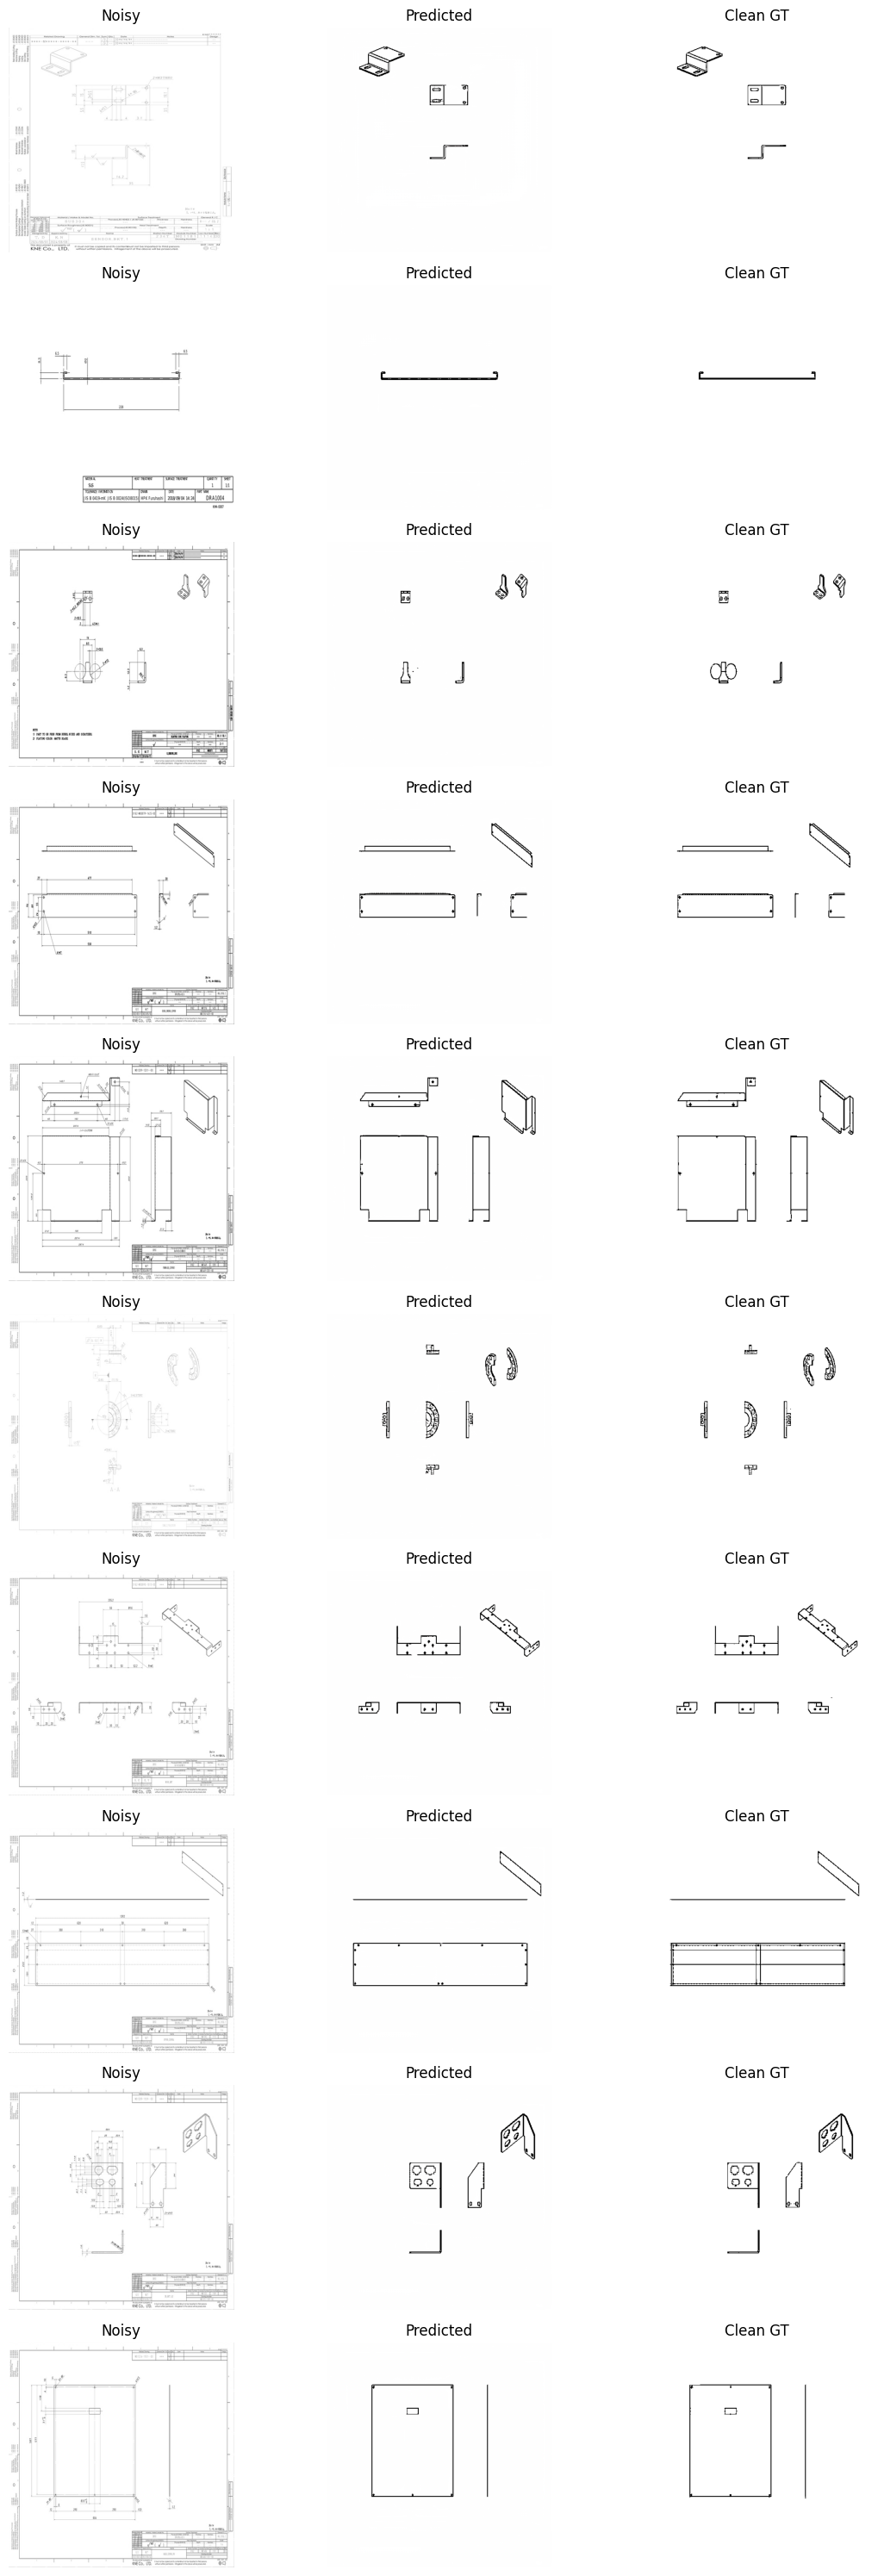

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_predictions(model, dataset, device, num_samples=10):
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(12, num_samples * 3))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            noisy, clean = dataset[idx]

            noisy_in = noisy.unsqueeze(0).to(device)
            pred = model(noisy_in)

            noisy = noisy.permute(1, 2, 0).cpu()
            clean = clean.permute(1, 2, 0).cpu()
            pred  = pred.squeeze(0).permute(1, 2, 0).cpu()

            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(noisy)
            plt.title("Noisy")
            plt.axis("off")

            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(pred)
            plt.title("Predicted")
            plt.axis("off")

            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(clean)
            plt.title("Clean GT")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, dataset, device, num_samples=10)


In [ ]:
model_path = "unet_cbam_iou_denoiser.pth"
torch.save(model.state_dict(), model_path)
print("Model saved as:", model_path)

from google.colab import files
files.download("unet_cbam_iou_denoiser.pth")


Model saved as: unet_cbam_iou_denoiser.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>